In [1]:
import pandas as pd
import numpy as np
import pylab as pl
import sklearn.utils as util

from sklearn import ensemble
from sklearn.metrics import mean_squared_error

%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Decision tree

In [2]:
# Calculate impurity in node
def node_impurity(y):
    
    mean = np.mean(y)
    delta = np.subtract(y, mean)
    return np.dot(delta, delta)

# Calculate normalized impurity in node
def node_impurity_norm(y):

    return node_impurity(y) / float(len(y))

# Find impurity after splitting
def impurity_after_split(y, i):

    l_samples = y[:i]
    r_samples = y[i:]
    N_l = i
    N_r = len(y) - i
    
    return N_l * node_impurity_norm(l_samples) + N_r * node_impurity_norm(r_samples)

# Find best split for node
def find_split(node):
    
    new_impurity = +inf
    min_impurity = +inf
    feature = None
    threshold = None
    l_rows = None
    r_rows = None
    
    for j in xrange(node.X.shape[1]):
        x_column = node.X[:, j]
        rows = np.argsort(x_column)
        x_sorted = x_column[rows]
        y_sorted = node.Y[rows]
        
        for i in xrange(1, len(x_sorted)):   
            
            if x_sorted[i] == x_sorted[i - 1]:
                continue
                
            new_impurity = impurity_after_split(y_sorted, i)
            
            if new_impurity < min_impurity:
                min_impurity = new_impurity
                feature = j
                threshold = (x_sorted[i] + x_sorted[i - 1]) / 2.0
                l_rows = rows[:i]
                r_rows = rows[i:]

    return feature, threshold, l_rows, r_rows
    
# Define a tree node
class CNode:
    
    def __init__(self, X, Y, feature=None, threshold=None, depth=0, parent=None):
        
        self.X = X
        self.Y = Y
        self.feature = feature
        self.threshold = threshold
        self.depth = depth
        self.parent = parent
        
        self.impurity = node_impurity_norm(Y)
        self.reduction = None
        self.mean = None
        
    def split(self):

        feature, threshold, l_rows, r_rows = find_split(self)
        
        if feature is not None:
            self.feature = feature
            self.threshold = threshold
            self.reduction = node_impurity(self.Y) - node_impurity(self.Y[l_rows]) - node_impurity(self.Y[r_rows])
            left_node = CNode(self.X[l_rows], self.Y[l_rows], depth=self.depth + 1)
            right_node = CNode(self.X[r_rows], self.Y[r_rows], depth=self.depth + 1)
            
        else:
            left_node = None
            right_node = None
        
        return left_node, right_node
        
# Define a decision tree
class CTree:
    
    def __init__(self, max_depth=3, min_samples_split=2):
        
        self.nodes = []
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        
    def fit(self, X, Y):
        
        self.nodes = np.array([CNode(X, Y)])
        self.feature_importances = np.zeros(X.shape[1])
        todo = np.array([0])
        
        while todo.size > 0:
            index = todo[0]
            todo = todo[1:]
            
            if self.nodes[index].depth < self.max_depth and len(self.nodes[index].X) > self.min_samples_split:
                
                left, right = self.nodes[index].split()

                if left is not None:
                    N = len(self.nodes)
                    self.nodes[index].left = N
                    self.nodes[index].right = N + 1
                    left.parent = index
                    right.parent = index
                    self.nodes = np.append(self.nodes, [left, right])
                    feature = self.nodes[index].feature
                    self.feature_importances[feature] += self.nodes[index].reduction
                    todo = np.append(todo, [N, N + 1])
                    continue
                    
            self.nodes[index].mean = np.mean(self.nodes[index].Y)
            self.nodes[index].X = None
            self.nodes[index].Y = None
            
        self.feature_importances = self.feature_importances / float(np.sum(self.feature_importances))
                
        return self
        
    def predict(self, X):
        
        answer = np.zeros(X.shape[0])
        
        if len(self.nodes) == 0:
            return answer
        
        for i in xrange(X.shape[0]):
            index = 0
            
            while self.nodes[index].mean is None:
                feature = self.nodes[index].feature
                threshold = self.nodes[index].threshold
                if X[i, feature] <= threshold:
                    index = self.nodes[index].left
                else:
                    index = self.nodes[index].right
            answer[i] = self.nodes[index].mean
            
        return answer

# Stochastic gradient boosting

In [3]:
# Sampling
def sampleData(X, Y, sample):
    
    x, y = util.shuffle(X, Y)
    offset = int(x.shape[0] * sample)
    
    return x[:offset], y[:offset]

# Define regressor class
class MyRegressor:
    
    def __init__(self, n_estimators=100, max_depth=3, min_samples_split=2, learning_rate=0.1, subsample=0.5, verbose=0):
        
        self.n_estimators = n_estimators
        self.estimators = [None] * n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.learning_rate = learning_rate
        self.subsample = subsample
        self.verbose = verbose
        self.h = [0] * n_estimators
        
    def fit(self, X, Y):
        
        if self.verbose == 1:
            print "Iter\tTrain Loss"
        
        self.init_value = np.mean(Y)
        initial = np.empty(X.shape[0])
        initial.fill(self.init_value)
        self.loss = np.zeros(self.n_estimators)
        self.feature_importances = np.zeros(X.shape[1])
        
        for i in xrange(self.n_estimators):

            if i == 0:
                prev = initial
            else:
                prev = self.h[i - 1]
                
            G = Y - prev
            x, g = sampleData(X, G, self.subsample)
            
            self.estimators[i] = CTree(max_depth=self.max_depth, min_samples_split=self.min_samples_split)
            self.estimators[i].fit(x, g)
            self.feature_importances += self.learning_rate * self.estimators[i].feature_importances
            self.h[i] = prev + self.learning_rate * self.estimators[i].predict(X)
            self.loss[i] = mean_squared_error(self.h[i], Y)
               
            if self.verbose == 1:
                if i <= 10 or i % 10 == 0:
                    print "%d\t%0.4f" % (i, self.loss[i])
                    
        self.feature_importances = self.feature_importances / float(np.sum(self.feature_importances))
        
        return self
        
    def predict(self, X, Y=None):

        answer = np.empty(X.shape[0])
        answer.fill(self.init_value)
        
        if Y is not None:
            self.test_loss = np.zeros(self.n_estimators)
        
        for i in xrange(self.n_estimators):
            answer += self.learning_rate * self.estimators[i].predict(X)
            
            if Y is not None:
                self.test_loss[i] = mean_squared_error(answer, Y)

        return answer

# Load spam dataset

In [4]:
train_df = pd.read_csv("datasets/spam-train.txt", delim_whitespace=True, header=None)
test_df = pd.read_csv("datasets/spam-test.txt", delim_whitespace=True, header=None)

# Create matrices from dataframes
Y_train = train_df[0].as_matrix()
Y_test = test_df[0].as_matrix()

X_train = train_df.drop(0, axis=1).as_matrix()
X_test = test_df.drop(0, axis=1).as_matrix()

print "Spam train:\t%d rows x %d features" % (X_train.shape[0], X_train.shape[1])
print "Spam test:\t%d rows x %d features" % (X_test.shape[0], X_test.shape[1])

Spam train:	7093 rows x 102 features
Spam test:	10056 rows x 102 features


# Filter feature selection (CFS)

In [5]:
def correlation(a, b):
    mean_a = np.mean(a)
    mean_b = np.mean(b)
    
    delta_a = np.subtract(a, mean_a)
    delta_b = np.subtract(b, mean_b)
    
    numer = np.sum(delta_a * delta_b)
    denom = sqrt(np.dot(delta_a, delta_a)) * sqrt(np.dot(delta_b, delta_b))

    return numer / float(denom)

def corr_matrix(X):
    matrix = np.zeros((X.shape[1], X.shape[1]))
    
    for i in xrange(X.shape[1]):
        matrix[i, i] = 1
        for j in xrange(i + 1, X.shape[1]):
            matrix[i, j] = correlation(X[:, i], X[:, j])
            matrix[j, i] = matrix[i, j]
            
    return matrix

def filterFS(X, Y):
    all_features = np.arange(X.shape[1])
    features = []
    
    cross_corr = corr_matrix(X)
    y_corr = np.array([correlation(X_train[:, f], Y_train) for f in all_features])
    
    numer = 0
    denom = 1
    
    while len(all_features) > 0:
        best = all_features[0]
        max_cfs = -inf

        for f in all_features:

            f_cross = np.sum([cross_corr[f, j] for j in features])
            cfs = (numer + abs(y_corr[f]) / sqrt(denom + 2 * f_cross))

            if cfs > max_cfs:
                best = f
                max_cfs = cfs

        features.append(best)
        all_features = np.setdiff1d(all_features, [best], assume_unique=True)
    
    return np.array(features)

# Run regressor on feature subsets

In [6]:
params = {'n_estimators': 50, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.5, 'verbose': 0}
indices = filterFS(X_train, Y_train)
print indices

mse_train = []
mse_test = []
t = []

for n in xrange(X_train.shape[1]):
    if (n < 15) or (n < 30 and n % 5 == 0) or (n % 15 == 0) or (n == X_train.shape[1] - 1):
        
        t.append(n)
        cur_indices = indices[:(n + 1)]

        reg = MyRegressor(**params)
        reg.fit(X_train[:, cur_indices], Y_train)

        pred_train = reg.predict(X_train[:, cur_indices])
        pred_test = reg.predict(X_test[:, cur_indices])

        mse_train.append(mean_squared_error(pred_train, Y_train))
        mse_test.append(mean_squared_error(pred_test, Y_test))

        i = len(mse_train) - 1
        print "Number of features: %d\tTrain loss: %0.4f\tTest loss: %0.4f" % (n + 1, mse_train[i], mse_test[i])

[ 48  70  49 101  31  10  56   9   8  51  53  11  14  41  74  52  32  85
  71  76   4  99  12  29  83  13   3  89  75  50  80  98  78  73  87  90
  15   1   2  19  44  61  16  72  62  35  28  47  77  86 100  92  79  95
  46  88  17  91  42  39  96  94  57  43  97  93  18  38   0  81  64  65
  30  82  25  66   5  63  58  37  20  59  60  84  68   6  54  33  45  67
   7  22  69  34  27  55  36  23  24  21  26  40]
Number of features: 1	Train loss: 0.1531	Test loss: 0.1215
Number of features: 2	Train loss: 0.1154	Test loss: 0.1347
Number of features: 3	Train loss: 0.0960	Test loss: 0.1441
Number of features: 4	Train loss: 0.0757	Test loss: 0.1339
Number of features: 5	Train loss: 0.0717	Test loss: 0.1278
Number of features: 6	Train loss: 0.0596	Test loss: 0.1190
Number of features: 7	Train loss: 0.0603	Test loss: 0.1184
Number of features: 8	Train loss: 0.0569	Test loss: 0.1151
Number of features: 9	Train loss: 0.0532	Test loss: 0.0984
Number of features: 10	Train loss: 0.0533	Test loss: 0

In [7]:
for n in xrange(16, 20):
    
    cur_indices = indices[:(n + 1)]

    reg = MyRegressor(**params)
    reg.fit(X_train[:, cur_indices], Y_train)

    pred_train = reg.predict(X_train[:, cur_indices])
    pred_test = reg.predict(X_test[:, cur_indices])

    print "Number of features: %d\tTrain loss: %0.4f\tTest loss: %0.4f" % (n + 1,
                                                                           mean_squared_error(pred_train, Y_train),
                                                                           mean_squared_error(pred_test, Y_test))

Number of features: 17	Train loss: 0.0449	Test loss: 0.0928
Number of features: 18	Train loss: 0.0441	Test loss: 0.0900
Number of features: 19	Train loss: 0.0418	Test loss: 0.0640
Number of features: 20	Train loss: 0.0413	Test loss: 0.0690


# View selected features

In [8]:
print "Selected features:", indices[:19]  # [48, 70, 49, 101, 31, 10, 56, 9, 8, 51, 53, 11, 14, 41, 74, 52, 32, 85, 71]

Selected features: [ 48  70  49 101  31  10  56   9   8  51  53  11  14  41  74  52  32  85
  71]


# Plot train & test loss

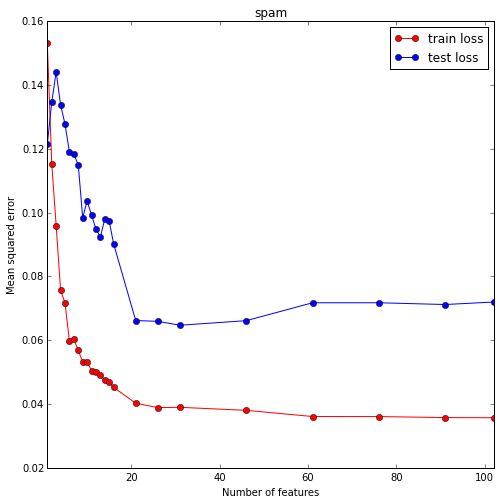

In [14]:
pl.figure(figsize=(8, 8))

N = X_train.shape[1]
tt = np.add(t, 1)

train, = pl.plot(tt, mse_train, color="red", linewidth=1.0, linestyle="-", marker='o')
test, = pl.plot(tt, mse_test, color="blue", linewidth=1.0, linestyle="-", marker='o')
pl.xlim(1, N)
pl.title("spam")
pl.legend([train, test], ['train loss', 'test loss'])
pl.xlabel("Number of features")
pl.ylabel("Mean squared error")

pl.show()

# Check on sklearn regressor

In [13]:
model_sk = ensemble.GradientBoostingRegressor(**params)
model_sk.fit(X_train, Y_train)
mse_sklearn = mean_squared_error(model_sk.predict(X_test), Y_test)
print "MSE on %d features:\t%0.10f" % (X_train.shape[1], mse_sklearn)

X_train_small = X_train[:, indices[:19]]
X_test_small = X_test[:, indices[:19]]

model_sk_small = ensemble.GradientBoostingRegressor(**params)
model_sk_small.fit(X_train_small, Y_train)
mse_sklearn_small = mean_squared_error(model_sk_small.predict(X_test_small), Y_test)
print "MSE on %d features:\t%0.10f" % (X_train_small.shape[1], mse_sklearn_small)

MSE on 102 features:	0.0694823701
MSE on 19 features:	0.0640259041
